In [1]:
# Re-import the necessary libraries after the reset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:

# Re-load the Excel file to get the sheets since the state was reset
file_path = 'Excel Files/Biome DB Tables.xlsm'

# Load all sheets into a dictionary of DataFrames
sheets = pd.read_excel(file_path, sheet_name=None)


c:\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Slicer List extension is not supported and will be removed
  warn(msg)


In [5]:

# Create the pivot tables again
erosion_pivot = sheets['Erosion'].pivot_table(index='E', columns='PV_Level', values='Category', aggfunc='first')
temperature_pivot = sheets['Temperature'].pivot_table(index='T', columns='PV_Level', values='Category', aggfunc='first')


C:\Users\nscha\AppData\Local\Temp\ipykernel_30828\2403651682.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numerical_pivot_table = pivot_table.applymap(lambda biome: biome_id_map.get(biome, None))


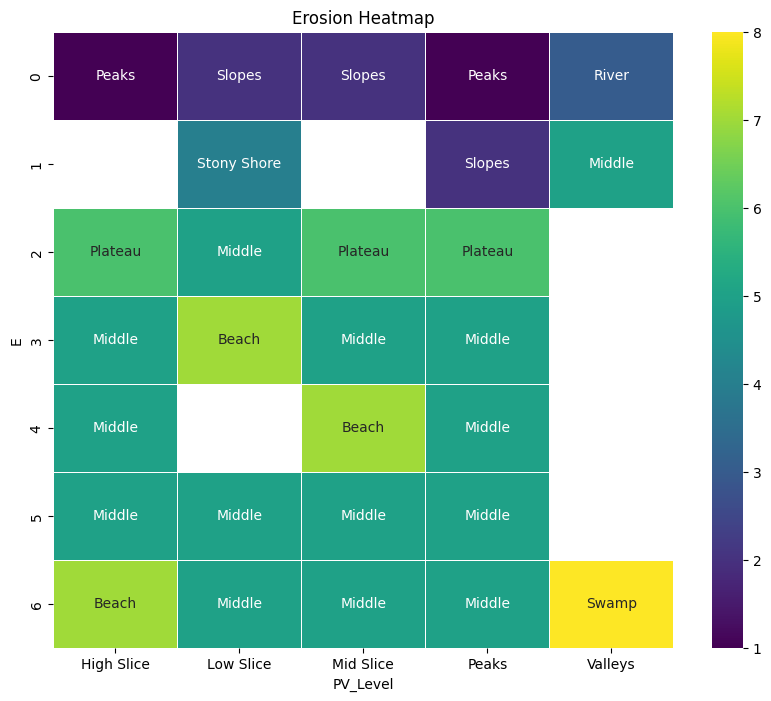

C:\Users\nscha\AppData\Local\Temp\ipykernel_30828\2403651682.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numerical_pivot_table = pivot_table.applymap(lambda biome: biome_id_map.get(biome, None))


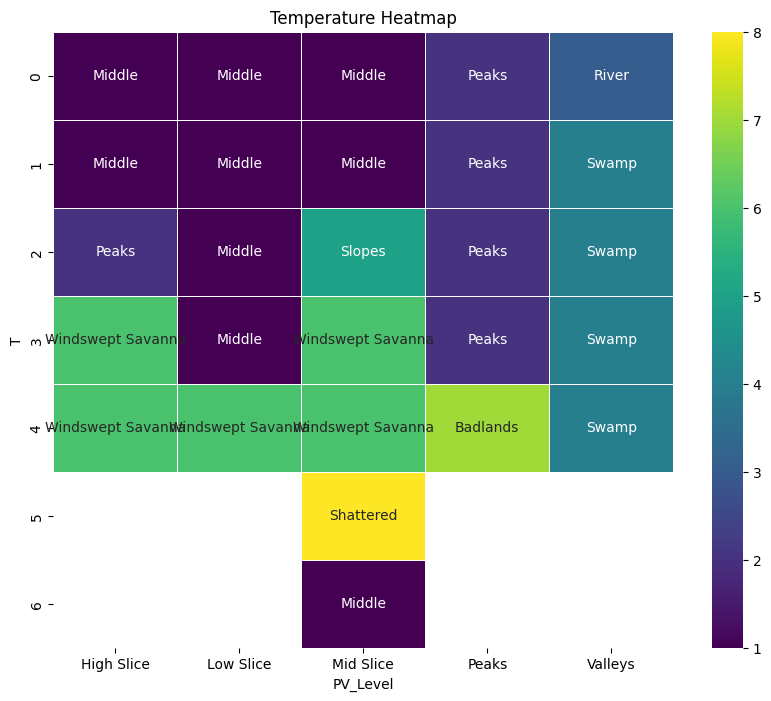

In [6]:

# Function to map biome names to numerical IDs and create a heatmap
def map_biomes_to_ids_and_create_heatmap(pivot_table, title):
    # Flatten the pivot table and drop NaN values to get unique biome names
    unique_biomes = pd.Series(pivot_table.values.ravel()).dropna().unique()
    
    # Create a dictionary to map biome names to numerical IDs
    biome_id_map = {biome: i for i, biome in enumerate(unique_biomes, start=1)}
    
    # Replace biome names in the pivot table with their corresponding IDs
    numerical_pivot_table = pivot_table.applymap(lambda biome: biome_id_map.get(biome, None))
    
    # Create a heatmap with numerical IDs
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_pivot_table, annot=pivot_table.to_numpy(), fmt="", cmap="viridis", linewidths=.5)
    plt.title(title)
    plt.show()

# Generate the heatmaps with biome IDs and names
map_biomes_to_ids_and_create_heatmap(erosion_pivot, "Erosion Heatmap")
map_biomes_to_ids_and_create_heatmap(temperature_pivot, "Temperature Heatmap")


C:\Users\nscha\AppData\Local\Temp\ipykernel_30828\3967726402.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numerical_pivot_table_swapped = pivot_table_swapped.applymap(lambda biome: biome_id_map.get(biome, None))


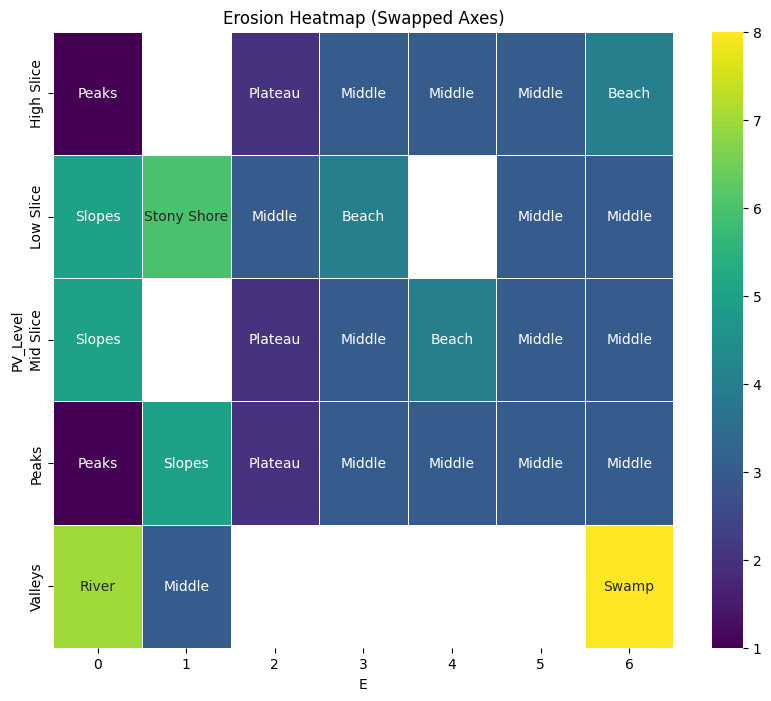

C:\Users\nscha\AppData\Local\Temp\ipykernel_30828\3967726402.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numerical_pivot_table_swapped = pivot_table_swapped.applymap(lambda biome: biome_id_map.get(biome, None))


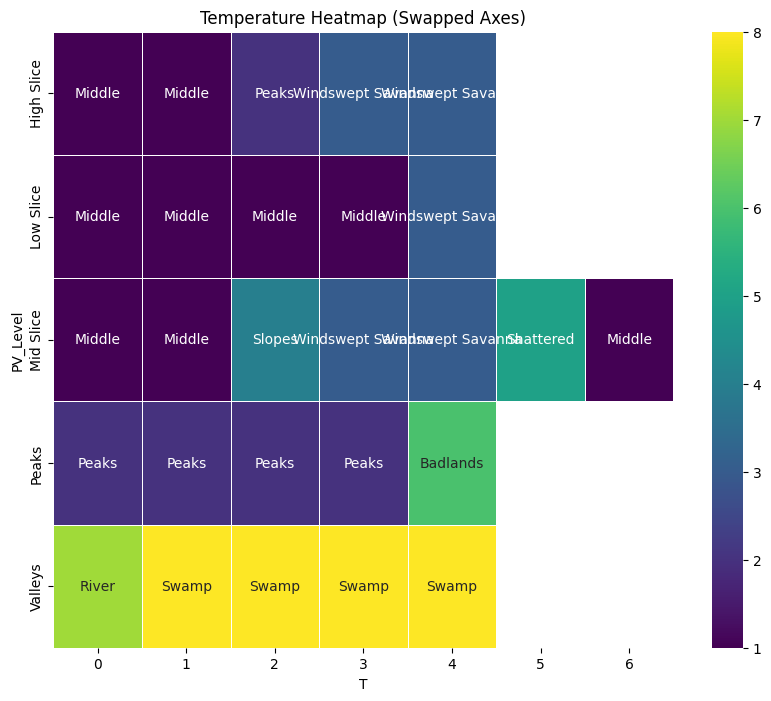

In [7]:
# Function to swap axes in the pivot table and recreate the heatmap
def map_biomes_to_ids_and_create_swapped_heatmap(pivot_table, title):
    # Transpose the pivot table to swap axes
    pivot_table_swapped = pivot_table.transpose()
    
    # Flatten the transposed pivot table and drop NaN values to get unique biome names
    unique_biomes = pd.Series(pivot_table_swapped.values.ravel()).dropna().unique()
    
    # Create a dictionary to map biome names to numerical IDs
    biome_id_map = {biome: i for i, biome in enumerate(unique_biomes, start=1)}
    
    # Replace biome names in the pivot table with their corresponding IDs
    numerical_pivot_table_swapped = pivot_table_swapped.applymap(lambda biome: biome_id_map.get(biome, None))
    
    # Create a heatmap with numerical IDs
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_pivot_table_swapped, annot=pivot_table_swapped.to_numpy(), fmt="", cmap="viridis", linewidths=.5)
    plt.title(title)
    plt.show()

# Generate the heatmaps with swapped axes
map_biomes_to_ids_and_create_swapped_heatmap(erosion_pivot, "Erosion Heatmap (Swapped Axes)")
map_biomes_to_ids_and_create_swapped_heatmap(temperature_pivot, "Temperature Heatmap (Swapped Axes)")


In [13]:
# Define the custom order for 'PV_Level'
pv_order = ['Peaks', 'High Slice', 'Mid Slice', 'Low Slice', 'Valleys']

# Reindex the 'Erosion' pivot table to have 'PV_Level' in the specified order
erosion_pivot = erosion_pivot[pv_order]

erosion_pivot

PV_Level,Peaks,High Slice,Mid Slice,Low Slice,Valleys
E,,,,,
0,Peaks,Peaks,Slopes,Slopes,River
1,Slopes,NaN,NaN,Stony Shore,Middle
2,Plateau,Plateau,Plateau,Middle,NaN
3,Middle,Middle,Middle,Beach,NaN
4,Middle,Middle,Beach,NaN,NaN
5,Middle,Middle,Middle,Middle,NaN
6,Middle,Beach,Middle,Middle,Swamp


In [9]:
def combine_erosion_temperature(erosion_pivot, temperature_pivot):
    combined_pivot = erosion_pivot.copy()
    for col in erosion_pivot.columns:
        for row in erosion_pivot.index:
            biome = erosion_pivot.loc[row, col]
            if pd.notna(biome):
                # Find the temperature value(s) for this biome
                temp_values = temperature_pivot[temperature_pivot == biome].stack().index.get_level_values('T')
                if not temp_values.empty:
                    # Take the average temperature for this biome
                    combined_pivot.loc[row, col] = temp_values.mean()
                else:
                    # If the biome is not found in the temperature data, we can assign a default value or NaN
                    combined_pivot.loc[row, col] = np.nan
    return combined_pivot

c:\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


TypeError: Image data of dtype object cannot be converted to float

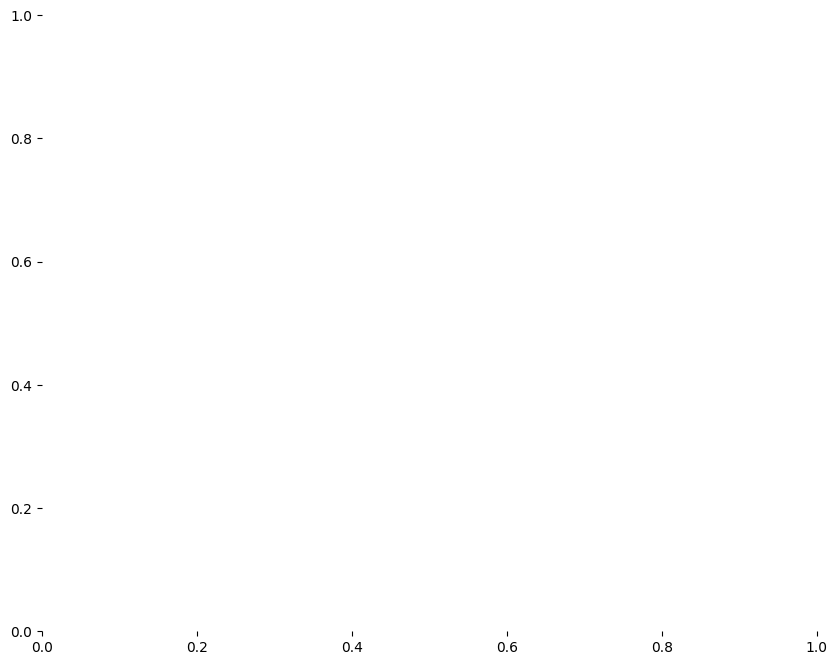

In [10]:
# Create the combined pivot table
combined_pivot = combine_erosion_temperature(ordered_erosion_pivot, ordered_temperature_pivot)

# Now, we create a heatmap using the 'Erosion' pivot for positioning and 'Temperature' data for the color scheme
plt.figure(figsize=(10, 8))
sns.heatmap(combined_pivot, annot=ordered_erosion_pivot.to_numpy(), fmt="", cmap="coolwarm", linewidths=.5)
plt.title("Combined Erosion and Temperature Heatmap")
plt.xlabel("Erosion")
plt.ylabel("PV Level")
plt.show()